# Where to park my bike

Hey, man! If you landed here, you probably want to see the result of this code: [serve yourself](parkmybike.html).
This is a small projects which grew up alongside other projects on Paris, mobility, and #opendata and #smartcity, as [Timing Paris](https://github.com/astyonax/TimingParis) and [Heart Beat of Paris](https://github.com/astyonax/heartbeat-traffic). 

Here I take the problem of an *inter-modal* commuter who wants to go to the most convenient subway station by bike instead of, e.g., taking connecting metros or walking. Rather academicly, or if this commuter is polite, this poses the problem of parking the bike *near* the subway entrance on a dedicated space which does not annoy other peoples. 

Stated in another way: How do we correlate bike parkings and subway entrances? 
Turns out that, thanks to OpenStreetMaps, cities can be queried as databases  (eg, the [OverPass API](http://wiki.openstreetmap.org/wiki/Overpass_API))
and from that we get all that is needed.

Undoubtely, I may have spent more on this to get more refined data, but don't be shy and open a *pull request* with enhancements!!

---

## Steps

Thus, here follow the steps needed to recreate (and update) the map.

0. You need a working OSRM server locally, with the db of Paris (or ile-de-france). 

1. Query OpenStreetMaps for bike parks and subway entraces: `scripts/queries.py` .
*Requirements*: `dill` and `overpy` (for OSM overpass API)

2. Make map between stations and top 10 nearest bike parks and viceversa:  `scripts/filtering.py`
*Requirements*: `numba, dill, pandas, numpy`

3. The following cells make sense of the data and generate the crucial geojson, and the bare html.

In [9]:
%pylab inline
import pandas as pd
import numpy as np
import dill
from string import atoi
import geojson as gj
from tqdm import tqdm_notebook as tqdm
from urllib2 import urlopen
import json
import polyline
import sys
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


/home/astyonax/.anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
# functions to retrieve a station or a bike park from the map of the top 10 nearest bike parks or stations respectively
def getstat(idx):
    return table_stations[table_stations.id==idx]
def getpark(idx):
    return table_pbike[table_pbike.id==idx]
def dstr(x):
    out = u""
    x = x.values[0]
    for i,j in x.iteritems():
        if 'source' not in i:
            out +=u"{0:s}:{1:s} -- \n".format(i,j)
    return out.strip()

In [5]:
table_pbike = pd.read_pickle('table_pbike.pkl')
table_stations = pd.read_pickle('table_stations.pkl')
data = dill.load(open('top10s.dill','rb'))
stat2park = data['stat2park']
park2stat = data['park2stat']

In [22]:
table_stations.head()

,id,lat,lon,tags
0,250656805,48.839508,2.301319,"{u'railway': u'subway_entrance', u'wheelchair'..."
1,256441196,48.852563,2.406038,"{u'wheelchair': u'no', u'ref': u'3', u'railway..."
2,256441197,48.852589,2.406224,"{u'wheelchair': u'no', u'ref': u'2', u'railway..."
3,256441199,48.852911,2.405953,"{u'wheelchair': u'no', u'ref': u'1', u'railway..."
4,256442277,48.853653,2.410406,"{u'railway': u'subway_entrance', u'ref': u'3',..."


In [25]:
table_stations.count()

id      852
lat     852
lon     852
tags    852
dtype: int64

In [31]:
print type(stat2park)
print stat2park.head()
print stat2park.count()

<class 'pandas.core.series.Series'>
0    [[0.186178390495, (286845307.0, 1232772979)], ...
1    [[0.0920411190939, (286846481.0, 4089581330)],...
2    [[0.349999822665, (319695113.0, 1014002249)], ...
3    [[0.0250383401361, (319702726.0, 4577464092)],...
4    [[0.174200387678, (321322278.0, 321203628)], [...
dtype: object
2366


## Visualize easy statistics

In [7]:
# get nearest, 2nd nearest and 3rd from park2stat (see filtering.py)
distances0 = [d[0][0]*1000 for d in park2stat]
distances1 = [d[1][0]*1000 for d in park2stat]
distances2 = [d[2][0]*1000 for d in park2stat]

Populating the interactive namespace from numpy and matplotlib


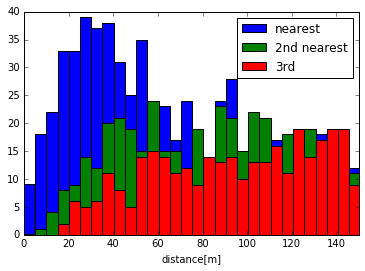

In [10]:
%pylab inline
import pylab as plt
bins = np.linspace(0,1000,200)

cs=False
plt.hist(distances0,bins=bins,cumulative=cs);
plt.hist(distances1,bins=bins,cumulative=cs);
plt.hist(distances2,bins=bins,cumulative=cs);
plt.xlim(0,150)
plt.gca().set_xlabel('distance[m]')
plt.gca().legend(['nearest','2nd nearest','3rd'])

In [12]:
tmp=[]
for row_stat in park2stat:
    for pbike in row_stat:
        d,(_,idpark)=pbike
        park=getpark(idpark)
        capacity = np.nan
        try:
            capacity = park.tags.values[0]['capacity']
            capacity = atoi(capacity)
            tmp.append({'distance':d,
                        'capacity':capacity,
                        'ids':park.id.values[0]})
        except KeyError:
            pass

df = pd.DataFrame(columns=['distance','ids','capacity'],data=tmp)
df.sort_values('distance',inplace=True)
df.drop_duplicates(subset='ids',inplace=True)
df.dropna(inplace=True)

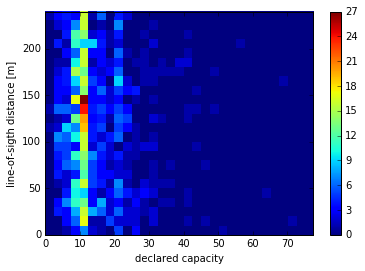

In [13]:
# plt.hist2d(df.capacity,df.distance*1000,bins=[np.arange(0,80,2.5),np.arange(0,250,10)]);
plt.hist2d(df.capacity,df.distance*1000,bins=[np.arange(0,80,2.5),np.arange(0,250,10)]);
plt.xlabel('declared capacity')
plt.ylabel('line-of-sigth distance [m]')
plt.colorbar()

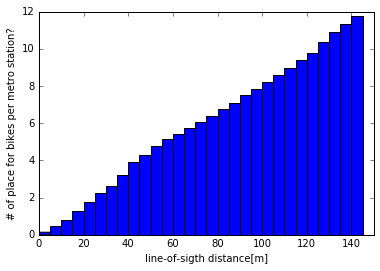

In [32]:
plt.hist(df.distance*1000,weights=df.capacity*1./table_stations.shape[0],bins=np.arange(0,150,5),cumulative=1);
plt.xlim(0,150)
plt.xlabel('line-of-sigth distance[m]')
plt.ylabel('# of place for bikes per metro station')

## Make geojson

Note that I ran this code last time on July '17. Since then, I remove the function `decode(encodedstr)` which did not appeared and changed the line saving the file geojson to encode the threshold distance, but I didn't rerun the cells. The git log contains the changes, and in case I broke something: sorry.

In [70]:
def route_p2p_osrm(p1,p2,mode='driving'):
    """
        ask to the local OSRM routing engine the way from p1 to p2
        p1:(lon, lat)
        p2:(lon,lat)
    """
    route_url="http://localhost:5000/route/v1/{mode:s}/{lon1:.5f},{lat1:.5f};{lon2:.5f},{lat2:.5f}?geometries=geojson&overview=full&steps=false"
    ((lon1,lat1),(lon2,lat2))=p1,p2
    request = route_url.format(lat1=lat1,lon1=lon1,lat2=lat2,lon2=lon2,mode=mode)
    response = urlopen(request).read()
    route = json.loads(response)

    distance = route['routes'][0]['distance'] # meters
    path = route['routes'][0]['geometry']
    
    return distance,path

route_p2p_osrm((2.30095, 48.83950),(2.301319, 48.83951))

(48.3,
 {u'coordinates': [[2.300951, 48.839534],
   [2.300951, 48.839534],
   [2.300878, 48.839548],
   [2.30114, 48.839635],
   [2.301261, 48.839656],
   [2.301309, 48.839581],
   [2.301272, 48.839568]],
  u'type': u'LineString'})

In [71]:


def capacity_to_color(x):
    # this function is used to assign a color to the bike parks markers
    # assign red if x>5, blue for 10<x<20, and green for x>20
    # else grey
    if x>20:return "#00ff00"
    if x>10:return "#0000ff"
    if x>5 :return "#ff0000"
    return "#cccccc"

DISTANCE = 100 # meters
# 1. for each park within the top 10 of each station
# 2. get its capacity (will map to color in point 4.)
# 3. compute path and path distance with OSRM routing (only by car so far)
# 4. if distance smaller than threshold, make a geojeson point and feature associated to the point
# 5. store the point in the `points` list
# 6. store the line in a `lin` list which contains all the lines going to this station (see point 1.)
# 7. at the end of the loop over parks, make a geojson multilinestring out of `lin` and add to `lines`
# 8. at the very end, put lines and point togheter and make a FeatureCollection out of everythings and dump as geojson
# now  I repeat, with code

# 0. declare lists
features = []
points = []
lines  = []

for row_stat in tqdm(park2stat):
    d,(idstat,idpark)=row_stat[0]
    stat = getstat(idstat)    
    slat = stat.lat.values[0]
    slon = stat.lon.values[0]
    lin = []
    # 1. for each park within the top 10 of each station
    for pbike in row_stat:
        d,(_,idpark)=pbike
        park=getpark(idpark)
        # get attributes
        lat = park.lat.values[0]
        lon = park.lon.values[0]
        # 2. get its capacity (will map to color in point 4.)
        try:
            capacity = park.tags.values[0]['capacity']
            capacity = atoi(capacity)
        except:
            capacity = -1
        # 3. compute path and path distance with OSRM routing (only by car so far)
        d,line = route_p2p_osrm((lon,lat),(slon,slat))
        # 4. if distance smaller than threshold, make a geojeson point and feature associated to the point
        if d<=DISTANCE:
            _p = gj.Point((lon,lat)) 
            # dict keys for properties are those defined by leaflet, not just ok-ish names
            p = gj.Feature(geometry=_p,properties={'title':'capacity {0:d}'.format(capacity),
                                                  "marker-color": "#ffffff",   
                                                  "marker-symbolcolor": capacity_to_color(capacity)})
            # 5. store the point in the `points` list
            points.append(p)
            # 6. store the line in a `lin` list which contains all the lines going to this station (see point 1.)
            lin.append(line['coordinates'])
    # 7. at the end of the loop over parks, make a geojson multilinestring out of `lin` and add to `lines`
    lines.append(gj.Feature(geometry=gj.MultiLineString(lin),properties={}))
    
# 8. at the very end, put lines and point togheter and make a FeatureCollection out of everythings and dump as geojson
points.extend(lines)
with open('data/within{0:d}m.geojson'.format(DISTANCE),'w') as fout:
     print >> fout, gj.dumps(gj.FeatureCollection(points))

Widget Javascript not detected.  It may not be installed or enabled properly.


## Interactive map
This code download the needed js files and writes the required html code to a file

In [26]:
from IPython.core.display import HTML

print 'do not donwload the easymap library. I made changes to the sourcecode to remove the shadow and improve speed'
# !wget https://raw.githubusercontent.com/Lapizistik/leaflet-easymap/master/js/leaflet-easymap.js
# !mkdir js
# !mv leaflet-easymap.js js -v

do not donwload the easymap library. I made changes to the sourcecode to remove the shadow and improve speed


**If you run the next cell you overwrite the webpage, not the data**

In [11]:
# page="""<html>
# <head>
#     <!-- include leaflet css and javascript -->
#     <link rel="stylesheet" href="https://unpkg.com/leaflet@1.1.0/dist/leaflet.css" />
#     <script src="https://unpkg.com/leaflet@1.1.0/dist/leaflet.js" ></script>

#     <!-- the leaflet easymap javascript -->
#     <!-- include this _after_ the leaflet javascript -->
#     <script src="js/leaflet-easymap.js"></script>
        
#     <style type="text/css">
#       .leasymap {
#         /* Important: the element needs a height! */
#         height: 500px; /* adjust this as you need it */
#         width: 100%; /* adjust this as you need it */
#         /* the following css is optional */
#         border: 0px solid black;
#         margin:5px;
#       }
#     </style>
# </head>
# <body>
#     <a href='parkmybike.html' target=_blank>open me </a>
#     <div class="leasymap" data-locate="true" data-geojson="within100m.geojson" data-origin="geojson"></div>
# </body>
# </html>
# """
# with open('parkmybike.html','w') as fout:
#     print >> fout,page

# # HTML(page)